In [1]:
#Import the dependacies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [2]:
#Import the functional tensorflow api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [3]:
import tensorflow as tf

# Clear any existing TensorFlow session
tf.keras.backend.clear_session()

# Configure a new session with memory growth enabled
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpu,
            [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    except RuntimeError as e:
        print(e)

In [4]:
data = "data"
positive = "positive"
negative = "negative"
anchor = "anchor"

# Setup paths
POS_PATH = os.path.join(data, positive)
NEG_PATH = os.path.join(data, negative)
ANC_PATH = os.path.join(data, anchor)

# Make the directories with exist_ok=True
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [14]:
# Move the dataset to negative data
#for directory in os.listdir('lfw-deepfunneled'):
    # Create the full path to the subdirectory
    #dir_path = os.path.join('lfw-deepfunneled', directory)
    
    # Only process if it's a directory
    #if os.path.isdir(dir_path):
        #for file in os.listdir(dir_path):
            #EX_PATH = os.path.join('lfw-deepfunneled', directory, file)
            #NEW_PATH = os.path.join(NEG_PATH, file)
            #os.replace(EX_PATH, NEW_PATH)

In [5]:
#establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    #Cut down the frame to 250x250 image
    frame = frame[200:450+250, 800:1050+250, :] 

    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


[ WARN:0@9.009] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
2025-02-15 19:48:40.963 python[5119:179145] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2025-02-15 19:48:43.219 python[5119:179145] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-15 19:48:43.219 python[5119:179145] +[IMKInputSession subclass]: chose IMKInputSession_Modern


: 

In [5]:
plt.imshow(frame)  # This will give you a 250x250 image

NameError: name 'frame' is not defined

In [5]:
import tensorflow as tf
import glob
import os

# For the directories that work as-is
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)

# Choose either Option 1 OR Option 2:

# Option 1: Using glob pattern (simpler approach)
neg_files = glob.glob(os.path.join(NEG_PATH, '**/*.jpg'), recursive=True)
negative = tf.data.Dataset.from_tensor_slices(neg_files).take(300)

# OR

# Option 2: Using os.walk
def get_all_jpg_files(directory):
    jpg_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                jpg_files.append(os.path.join(root, file))
    return jpg_files

neg_files = get_all_jpg_files(NEG_PATH)
negative = tf.data.Dataset.from_tensor_slices(neg_files).take(300)

2025-02-15 19:49:11.732934: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-02-15 19:49:11.732987: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-02-15 19:49:11.733007: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-02-15 19:49:11.733445: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-15 19:49:11.733904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data/anchor/72a13458-eaec-11ef-a0d5-521e96a58973.jpg'

In [7]:
#preprocess/scale the data
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img/= 255.0
    return img

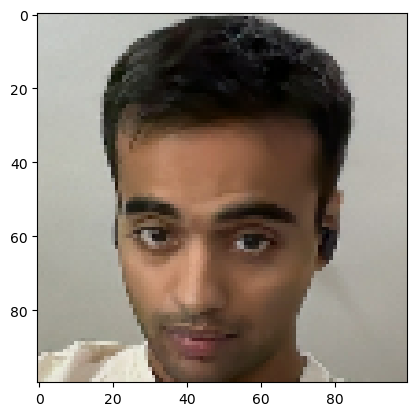

In [8]:
img = preprocess('data/anchor/7e9fa5e4-eab2-11ef-8cf1-521e96a58973.jpg')
plt.imshow(img)

In [9]:
#create labelled dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [10]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [11]:
#build test and train partition
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [12]:
#build the dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [13]:
sample = data.as_numpy_iterator()

In [14]:
samp = sample.next()

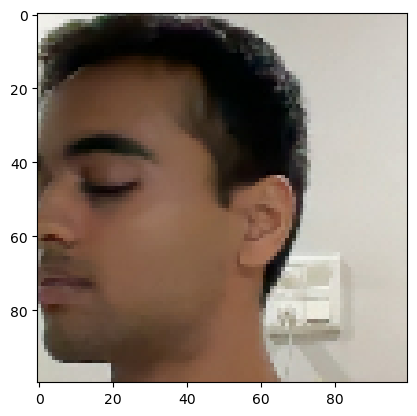

In [15]:
plt.imshow(samp[0])

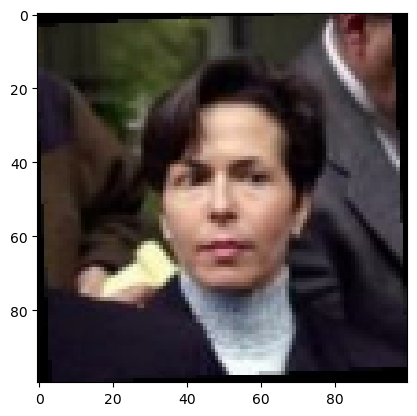

In [16]:
plt.imshow(samp[1])

In [17]:
samp[2]

0.0

In [18]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
#building embedding layer
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')

    #first block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #FInal embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs= [inp], outputs= [d1], name= 'embedding')

In [30]:
model= make_embedding()
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26